### this setcion code is for reading picture both smo and nosmo ,and convert them to tfRecode format! ###!!


In [1]:
#https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = '.'

#State where your log file is at. If it doesn't exist, create it.
log_dir = './out001/'

#State where your checkpoint file is
checkpoint_file = './inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 299

#State the number of classes to predict:
num_classes = 2

#State the labels file and read it

labels_file = log_dir+'./labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}

# a dictionary of datasets_data_dir name
#datasets_data_dir = '/home/aewin/work/anaconda3/code/models/research/slim/smorking'
datasets_data_dir = '/home/aewin/work/anaconda3/code/V001/smodata/t'

#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 15 #3 mins every time

#State your batch size
batch_size = 32



#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name



#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.0002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2
file_pattern = 'smotfrecord_train_%s.tfrecord'


items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:nosmo, 1:smo'
}


In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import slim
import os
import time

def get_split(split_name, dataset_dir, file_pattern=file_pattern):
    '''
    Obtains the split - training or validation - to create a Dataset class for feeding the examples into a queue later on. This function will
    set up the decoder and dataset information all into one Dataset class so that you can avoid the brute work later on.
    Your file_pattern is very important in locating the files later. 
    INPUTS:
    - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
    - dataset_dir(str): the dataset directory where the tfrecord files are located
    - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data
    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation later.
    '''

    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError('The split_name %s is not recognized. Please input either train or validation as the split_name' % (split_name))

    #Create the full path for a general file_pattern to locate the tfrecord_files
    file_pattern_path = file_pattern

    #Count the total number of examples in all of these shard
    num_samples = 0
    '''
    file_pattern_for_counting = '200label_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir) if file.startswith(file_pattern_for_counting)]
    print(file_pattern_for_counting)
    '''
    tfrecords_to_count = [os.path.join(dataset_dir,file) for file in os.listdir(dataset_dir)]
         
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1

    
    print(tfrecords_to_count)
    
    #Create a reader, which must be a TFRecord reader in this case
    reader = tf.TFRecordReader

    #Create the keys_to_features dictionary for the decoder
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    #Create the items_to_handlers dictionary for the decoder.
    items_to_handlers = {
    'image': slim.tfexample_decoder.Image(),
    'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    #Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    #Create the labels_to_name file
    labels_to_name_dict = labels_to_name
    
    print(tfrecords_to_count)

    
    
    #Actually create the dataset
    dataset = slim.dataset.Dataset(
        data_sources = tfrecords_to_count,
        decoder = decoder,
        reader = reader,
        num_readers = 4,
        num_samples = num_samples,
        num_classes = num_classes,
        labels_to_name = labels_to_name_dict,
        items_to_descriptions = items_to_descriptions)
    
    
    
    
    print(dataset.data_sources)
    return dataset


#get_split('train', datasets_data_dir, file_pattern=file_pattern)
#file_pattern = 'smotfrecord_validation_%s.tfrecord'
#get_split('validation', datasets_data_dir, file_pattern=file_pattern)

In [3]:
from datasets import flowers
import setdate #from fllower.py
import inception_preprocessing


def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.

    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing

    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).

    '''
    #First create the data_provider object
    '''   
    参数说明如下：
    dataset：Dataset 类实例
    num_readers：并行阅读器数量
    reader_kwargs=None：阅读器关键配置字典
    shuffle：是否打乱
    num_epochs：每个数据源被读取的次数，如果设为None数据将会被无限循环的读取
    common_queue_capacity：读取数据队t列的容量，默认为256
    common_queue_min：读取数据队列的最小容量
    record_key：（不是很理解）
    seed=None：打乱是的种子
    scope=None：范围
    ''' 
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity = 24 + 3 * batch_size,
        common_queue_min = 24)

    #Obtain the raw image using the get method
    raw_image, label = data_provider.get(['image', 'label'])

    '''
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(7):
                np_image, np_label = sess.run([raw_image, label])
                print(np_label)
                height, width, _ = np_image.shape
                #class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                #plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

    '''
    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)
    
    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)

    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_images, labels = tf.train.batch(
        [image, raw_image, label],
        batch_size = batch_size,
        num_threads = 4,
        capacity = 4 * batch_size,
        allow_smaller_final_batch = True)

    return images, raw_images, labels

load_batch(get_split('train', datasets_data_dir, file_pattern=file_pattern)
, batch_size=batch_size)


['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type

(<tf.Tensor 'batch:0' shape=(?, 299, 299, 3) dtype=float32>,
 <tf.Tensor 'batch:1' shape=(?, 299, 299, 3) dtype=uint8>,
 <tf.Tensor 'batch:2' shape=(?,) dtype=int64>)

In [4]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2018-12-18 03:08:24


In [5]:

#from datasets import flowers

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import slim
import os
from inception_resnet_v2v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
import time
#https://blog.gtwang.org/programming/tensorflow-read-write-tfrecords-data-format-tutorial/
#实例化了一个类，一个用于 tensorflow 计算和表示用的数据流图
'''  WHY using  tf.Graph().as_default():!!!!!!!!!!!!!!!
   Since a default graph is always registered, every op and variable is placed into the default graph. 
   The statement of  tf.Graph().as_default(): , however,creates a new graph and places everything (declared inside its scope) into this graph.
   If the graph is the only graph, it's useless. 
   But it's a good practice because if you start to work with many graphs it's easier to understand where ops and 
   vars are placed. 
   Since this statement costs you nothing, it's better to write it anyway. 
   Just to be sure that if you refactor the code in the future, 
   the operations defined belong to the graph you choose initially
'''
def run():
    with tf.Graph().as_default(): 
  
        
        #指定獲取有“train”的資料
        #dataset = get_split2('train',  './tf_train/','smorking_train_*.tfrecords')
        #dataset = get_split('train',  './tf_train/','smorking_train_*.tfrecords')
        
        dataset = get_split('train', datasets_data_dir, file_pattern=file_pattern)
        image, _, labels = load_batch(dataset, batch_size=batch_size)

 
        #Know the number steps to take before decaying the learning rate and batches per epoch
        num_batches_per_epoch = int(dataset.num_samples / batch_size)
        num_steps_per_epoch = num_batches_per_epoch #Because one step is one batch processed
        decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

        #Create the model inference
        with slim.arg_scope(inception_resnet_v2_arg_scope()):

            logits, end_points = inception_resnet_v2(image, num_classes = dataset.num_classes, is_training = True)

        #Define the scopes that you want to exclude for restoration
        exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
        variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

        #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
        one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

        #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
        loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
        total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

        #Create the global step for monitoring the learning_rate and training.
        global_step = get_or_create_global_step()
        #Define your exponentially decaying learning rate
        lr = tf.train.exponential_decay(
            learning_rate = initial_learning_rate,
            global_step = global_step,
            decay_steps = decay_steps,
            decay_rate = learning_rate_decay_factor,
            staircase = True)

        #Now we can define the optimizer that takes on the learning rate
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)

        #Create the train_op.
        train_op = slim.learning.create_train_op(total_loss, optimizer)

        #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
        predictions = tf.argmax(end_points['Predictions'], 1)
        probabilities = end_points['Predictions']
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update, probabilities)


        #Now finally create all the summaries you need to monitor and group them into one summary op.
        tf.summary.scalar('losses/Total_Loss', total_loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('learning_rate', lr)
        my_summary_op = tf.summary.merge_all()
        

        #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
        def train_step(sess, train_op, global_step):
            '''
            Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
            '''
            #Check the time for each sess run
            start_time = time.time()
            total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
            time_elapsed = time.time() - start_time

            #Run the logging to print some results
            print('global step %s: loss: %.4f (%.2f sec/step)' %( global_step_count, total_loss, time_elapsed))
            return total_loss, global_step_count

        #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
        #write_version=tf.train.SaverDef.V1# this is  for V1
        saver = tf.train.Saver(variables_to_restore)
        
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
        sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)

         
        #Run the managed session
        with sv.managed_session() as sess:


            for step in range(num_steps_per_epoch * num_epochs):
                print(step)
                #At the start of every epoch, show the vital information:
                if (step % num_batches_per_epoch) == 0:
                    print('Epoch %s/%s' %(step/num_batches_per_epoch + 1, num_epochs))
                    learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                    print('Current Learning Rate: %s' %(learning_rate_value))
                    print('Current Streaming Accuracy: %s' %(accuracy_value))

                    # optionally, print your logits and predictions for a sanity check that things are going fine.
                    logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                    print( 'logits: \n', logits_value)
                    print( 'Probabilities: \n', probabilities_value)
                    print( 'predictions: \n', predictions_value)
                    print( 'Labels:\n:', labels_value)

                #Log the summaries every 10 step.
                if (step % 10) == 0:
                    print('step % 10==0')
                    loss, _ = train_step(sess, train_op, sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    
                #If not, simply run the training step
                else:
                    loss, _ = train_step(sess, train_op, sv.global_step)

            #We log the final training loss and accuracy
            print('Final Loss: %s' %loss)
            print('Final Accuracy: %s' %sess.run(accuracy))
                          

            #Once all the training has been done, save the log files and checkpoint model
            print('Finished training! Saving model to disk now.')
            
            #sv.saver.save(sess, './model.ckpt', global_step = sv.global_step)
            
            sv.saver.save(sess, sv.save_path, global_step = sv.global_step)# this is  for V2
            

run()     

#import tensorflow as tf
#from tensorflow.python.framework import graph_io
#frozen = tf.graph_util.convert_variables_to_const#ants(sess, sess.graph_def, ["<name_of_the_output_node>"])
#graph_io.write_graph(frozen, './', 'inference_graph.pb', as_text=False)





['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Restoring parameters from ./out001/model.ckpt-20294
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_in

global step 20376: loss: 0.4899 (0.70 sec/step)
83
global step 20377: loss: 0.4782 (0.73 sec/step)
84
global step 20378: loss: 0.5788 (0.73 sec/step)
85
global step 20379: loss: 0.4727 (0.70 sec/step)
86
global step 20380: loss: 0.4779 (0.70 sec/step)
87
global step 20381: loss: 0.4732 (0.71 sec/step)
88
global step 20382: loss: 0.4860 (0.72 sec/step)
89
global step 20383: loss: 0.5509 (0.70 sec/step)
90
step % 10==0
global step 20384: loss: 0.4713 (0.72 sec/step)
91
global step 20385: loss: 0.4723 (0.72 sec/step)
92
global step 20386: loss: 0.5080 (0.72 sec/step)
93
global step 20387: loss: 0.5868 (0.71 sec/step)
94
global step 20388: loss: 0.4895 (0.70 sec/step)
95
global step 20389: loss: 0.4784 (0.70 sec/step)
96
global step 20390: loss: 0.4847 (0.72 sec/step)
97
global step 20391: loss: 0.4737 (0.69 sec/step)
98
global step 20392: loss: 0.4745 (0.69 sec/step)
99
global step 20393: loss: 0.4729 (0.71 sec/step)
100
step % 10==0
global step 20394: loss: 0.4735 (0.71 sec/step)
101
glo

global step 20487: loss: 0.4774 (0.69 sec/step)
194
global step 20488: loss: 0.5465 (0.69 sec/step)
195
global step 20489: loss: 0.5216 (0.71 sec/step)
196
global step 20490: loss: 0.4776 (0.71 sec/step)
197
global step 20491: loss: 0.4726 (0.71 sec/step)
198
global step 20492: loss: 0.4935 (0.71 sec/step)
199
global step 20493: loss: 0.4715 (0.72 sec/step)
200
step % 10==0
global step 20494: loss: 0.4955 (0.73 sec/step)
201
global step 20495: loss: 0.4816 (0.71 sec/step)
202
global step 20496: loss: 0.4974 (0.71 sec/step)
203
global step 20497: loss: 0.4753 (0.71 sec/step)
204
global step 20498: loss: 0.4825 (0.73 sec/step)
205
global step 20499: loss: 0.4973 (0.73 sec/step)
206
global step 20500: loss: 0.4800 (0.73 sec/step)
207
global step 20501: loss: 0.4883 (0.72 sec/step)
208
global step 20502: loss: 0.4918 (0.72 sec/step)
209
global step 20503: loss: 0.5115 (0.75 sec/step)
210
step % 10==0
global step 20504: loss: 0.6804 (0.73 sec/step)
211
global step 20505: loss: 0.5046 (0.73 

global step 20599: loss: 0.4866 (0.85 sec/step)
306
global step 20600: loss: 0.4726 (0.85 sec/step)
307
global step 20601: loss: 0.5452 (0.85 sec/step)
308
global step 20602: loss: 0.4821 (0.84 sec/step)
309
global step 20603: loss: 0.4811 (0.83 sec/step)
310
step % 10==0
global step 20604: loss: 0.4777 (0.84 sec/step)
311
global step 20605: loss: 0.5033 (0.84 sec/step)
312
global step 20606: loss: 0.4855 (0.83 sec/step)
313
global step 20607: loss: 0.4838 (0.85 sec/step)
314
global step 20608: loss: 0.6066 (0.84 sec/step)
315
global step 20609: loss: 0.5788 (0.83 sec/step)
316
global step 20610: loss: 0.4789 (0.86 sec/step)
317
global step 20611: loss: 0.4727 (0.84 sec/step)
318
global step 20612: loss: 0.5811 (0.84 sec/step)
319
global step 20613: loss: 0.7678 (0.84 sec/step)
320
step % 10==0
global step 20614: loss: 0.4963 (0.84 sec/step)
321
global step 20615: loss: 0.5012 (0.85 sec/step)
322
global step 20616: loss: 0.4755 (0.84 sec/step)
323
global step 20617: loss: 0.4983 (0.84 

global step 20732: loss: 0.4813 (0.86 sec/step)
439
global step 20733: loss: 0.4722 (0.87 sec/step)
440
step % 10==0
global step 20734: loss: 0.5432 (0.88 sec/step)
441
global step 20735: loss: 0.4967 (0.87 sec/step)
442
global step 20736: loss: 0.4717 (0.89 sec/step)
443
global step 20737: loss: 0.4792 (0.88 sec/step)
444
global step 20738: loss: 0.4735 (0.86 sec/step)
445
global step 20739: loss: 0.5099 (0.88 sec/step)
446
global step 20740: loss: 0.4716 (0.88 sec/step)
447
global step 20741: loss: 0.4765 (0.87 sec/step)
448
global step 20742: loss: 0.4943 (0.87 sec/step)
449
global step 20743: loss: 0.4847 (0.87 sec/step)
450
step % 10==0
global step 20744: loss: 0.5074 (0.87 sec/step)
451
global step 20745: loss: 0.4879 (0.87 sec/step)
452
global step 20746: loss: 0.6123 (0.86 sec/step)
453
global step 20747: loss: 0.4924 (0.87 sec/step)
454
global step 20748: loss: 0.4731 (0.87 sec/step)
455
global step 20749: loss: 0.4995 (0.88 sec/step)
456
global step 20750: loss: 0.4747 (0.86 

global step 20878: loss: 0.4865 (0.93 sec/step)
585
global step 20879: loss: 0.4984 (0.93 sec/step)
586
global step 20880: loss: 0.5505 (0.94 sec/step)
587
global step 20881: loss: 0.4938 (0.93 sec/step)
588
global step 20882: loss: 0.4771 (0.93 sec/step)
589
global step 20883: loss: 0.4919 (0.93 sec/step)
590
step % 10==0
global step 20884: loss: 0.5664 (0.94 sec/step)
591
global step 20885: loss: 0.4850 (0.93 sec/step)
592
global step 20886: loss: 0.4948 (0.93 sec/step)
593
global step 20887: loss: 0.4793 (0.93 sec/step)
594
global step 20888: loss: 0.4718 (0.94 sec/step)
595
global step 20889: loss: 0.4759 (0.94 sec/step)
596
global step 20890: loss: 0.4925 (0.93 sec/step)
597
global step 20891: loss: 0.7041 (0.92 sec/step)
598
global step 20892: loss: 0.4799 (0.92 sec/step)
599
global step 20893: loss: 0.4985 (0.93 sec/step)
600
step % 10==0
global step 20894: loss: 0.4835 (0.94 sec/step)
601
global step 20895: loss: 0.4742 (0.92 sec/step)
602
global step 20896: loss: 0.5427 (0.93 

global step 21024: loss: 0.4884 (0.92 sec/step)
731
global step 21025: loss: 0.4724 (0.94 sec/step)
732
global step 21026: loss: 0.4969 (0.92 sec/step)
733
global step 21027: loss: 0.4935 (0.92 sec/step)
734
global step 21028: loss: 0.5180 (0.92 sec/step)
735
global step 21029: loss: 0.4795 (0.92 sec/step)
736
global step 21030: loss: 0.4721 (0.94 sec/step)
737
global step 21031: loss: 0.5017 (0.92 sec/step)
738
global step 21032: loss: 0.4839 (0.94 sec/step)
739
global step 21033: loss: 0.4736 (0.92 sec/step)
740
step % 10==0
global step 21034: loss: 0.4765 (0.94 sec/step)
741
global step 21035: loss: 0.5011 (0.94 sec/step)
742
global step 21036: loss: 0.4751 (0.92 sec/step)
743
global step 21037: loss: 0.4847 (0.93 sec/step)
744
global step 21038: loss: 0.4923 (0.94 sec/step)
745
global step 21039: loss: 0.5779 (0.92 sec/step)
746
global step 21040: loss: 0.5064 (0.93 sec/step)
747
global step 21041: loss: 0.4873 (0.94 sec/step)
748
global step 21042: loss: 0.4787 (0.93 sec/step)
749

global step 21170: loss: 0.4725 (0.92 sec/step)
877
global step 21171: loss: 0.5073 (0.92 sec/step)
878
global step 21172: loss: 0.4904 (0.93 sec/step)
879
global step 21173: loss: 0.5027 (0.91 sec/step)
880
step % 10==0
global step 21174: loss: 0.5121 (0.92 sec/step)
881
global step 21175: loss: 0.4717 (0.92 sec/step)
882
global step 21176: loss: 0.4765 (0.93 sec/step)
883
global step 21177: loss: 0.5137 (0.93 sec/step)
884
global step 21178: loss: 0.5241 (0.92 sec/step)
885
global step 21179: loss: 0.4957 (0.90 sec/step)
886
global step 21180: loss: 0.4740 (0.92 sec/step)
887
global step 21181: loss: 0.5354 (0.91 sec/step)
888
global step 21182: loss: 0.4784 (0.92 sec/step)
889
global step 21183: loss: 0.5587 (0.92 sec/step)
890
step % 10==0
global step 21184: loss: 0.5152 (0.91 sec/step)
891
global step 21185: loss: 0.5336 (0.91 sec/step)
892
global step 21186: loss: 0.5004 (0.93 sec/step)
893
global step 21187: loss: 0.4739 (0.94 sec/step)
894
global step 21188: loss: 0.4990 (0.93 

global step 21316: loss: 0.5194 (0.91 sec/step)
1023
global step 21317: loss: 0.5129 (0.90 sec/step)
1024
global step 21318: loss: 0.4794 (0.91 sec/step)
1025
global step 21319: loss: 0.4731 (0.90 sec/step)
1026
global step 21320: loss: 0.4755 (0.90 sec/step)
1027
global step 21321: loss: 0.4759 (0.90 sec/step)
1028
global step 21322: loss: 0.5031 (0.91 sec/step)
1029
global step 21323: loss: 0.4788 (0.89 sec/step)
1030
step % 10==0
global step 21324: loss: 0.5099 (0.91 sec/step)
1031
global step 21325: loss: 0.9820 (0.91 sec/step)
1032
global step 21326: loss: 0.4730 (0.88 sec/step)
1033
global step 21327: loss: 0.6281 (0.94 sec/step)
1034
global step 21328: loss: 0.4756 (0.96 sec/step)
1035
global step 21329: loss: 0.4871 (0.94 sec/step)
1036
global step 21330: loss: 0.4747 (0.95 sec/step)
1037
INFO:tensorflow:global_step/sec: 1.02541
global step 21331: loss: 0.4714 (0.95 sec/step)
1038
global step 21332: loss: 0.5287 (0.96 sec/step)
1039
global step 21333: loss: 0.5296 (0.96 sec/ste

global step 21462: loss: 0.5037 (0.97 sec/step)
1169
global step 21463: loss: 0.5607 (0.97 sec/step)
1170
step % 10==0
global step 21464: loss: 0.5214 (0.96 sec/step)
1171
global step 21465: loss: 0.4800 (0.96 sec/step)
1172
global step 21466: loss: 0.4807 (0.97 sec/step)
1173
global step 21467: loss: 0.4761 (0.96 sec/step)
1174
global step 21468: loss: 0.4737 (0.96 sec/step)
1175
global step 21469: loss: 0.4967 (0.97 sec/step)
1176
global step 21470: loss: 0.5345 (0.95 sec/step)
1177
global step 21471: loss: 0.5134 (0.96 sec/step)
1178
global step 21472: loss: 0.5223 (0.97 sec/step)
1179
global step 21473: loss: 0.5440 (0.97 sec/step)
1180
step % 10==0
global step 21474: loss: 0.4825 (0.96 sec/step)
1181
global step 21475: loss: 0.4754 (0.88 sec/step)
1182
global step 21476: loss: 0.4854 (0.89 sec/step)
1183
global step 21477: loss: 0.4752 (0.90 sec/step)
1184
global step 21478: loss: 0.4860 (0.91 sec/step)
1185
global step 21479: loss: 0.4996 (0.89 sec/step)
1186
global step 21480: l

global step 21608: loss: 0.6859 (0.80 sec/step)
1315
global step 21609: loss: 0.4910 (0.81 sec/step)
1316
global step 21610: loss: 0.4757 (0.82 sec/step)
1317
global step 21611: loss: 0.4764 (0.83 sec/step)
1318
global step 21612: loss: 0.4723 (0.85 sec/step)
1319
global step 21613: loss: 0.4835 (0.88 sec/step)
1320
step % 10==0
global step 21614: loss: 0.7796 (0.90 sec/step)
1321
global step 21615: loss: 0.4924 (0.87 sec/step)
1322
global step 21616: loss: 0.4715 (0.87 sec/step)
1323
global step 21617: loss: 0.4762 (0.88 sec/step)
1324
global step 21618: loss: 0.4886 (0.88 sec/step)
1325
global step 21619: loss: 0.4768 (0.89 sec/step)
1326
global step 21620: loss: 0.4730 (0.89 sec/step)
1327
global step 21621: loss: 0.5656 (0.88 sec/step)
1328
global step 21622: loss: 0.5148 (0.87 sec/step)
1329
global step 21623: loss: 0.4719 (0.87 sec/step)
1330
step % 10==0
global step 21624: loss: 0.4936 (0.88 sec/step)
1331
global step 21625: loss: 0.4732 (0.87 sec/step)
1332
global step 21626: l

global step 21754: loss: 0.4936 (0.90 sec/step)
1461
global step 21755: loss: 0.4780 (0.90 sec/step)
1462
global step 21756: loss: 0.4934 (0.91 sec/step)
1463
global step 21757: loss: 0.4716 (0.92 sec/step)
1464
global step 21758: loss: 0.4881 (0.91 sec/step)
1465
global step 21759: loss: 0.6506 (0.91 sec/step)
1466
global step 21760: loss: 0.4985 (0.92 sec/step)
1467
global step 21761: loss: 0.4826 (0.91 sec/step)
1468
global step 21762: loss: 0.4936 (0.91 sec/step)
1469
global step 21763: loss: 0.5561 (0.91 sec/step)
1470
step % 10==0
global step 21764: loss: 0.4817 (0.92 sec/step)
1471
global step 21765: loss: 0.4791 (0.92 sec/step)
1472
global step 21766: loss: 0.4749 (0.91 sec/step)
1473
global step 21767: loss: 0.4720 (0.90 sec/step)
1474
global step 21768: loss: 0.4718 (0.90 sec/step)
1475
global step 21769: loss: 0.4826 (0.90 sec/step)
1476
global step 21770: loss: 0.4800 (0.91 sec/step)
1477
global step 21771: loss: 0.4896 (0.91 sec/step)
1478
global step 21772: loss: 0.4725 (

global step 21900: loss: 0.4728 (1.02 sec/step)
1607
global step 21901: loss: 0.4739 (1.02 sec/step)
1608
global step 21902: loss: 0.4772 (1.02 sec/step)
1609
global step 21903: loss: 0.4844 (1.02 sec/step)
1610
step % 10==0
global step 21904: loss: 0.4804 (1.02 sec/step)
1611
global step 21905: loss: 0.5236 (0.91 sec/step)
1612
global step 21906: loss: 0.4946 (0.94 sec/step)
1613
global step 21907: loss: 0.5188 (0.93 sec/step)
1614
global step 21908: loss: 0.4939 (0.94 sec/step)
1615
global step 21909: loss: 0.4799 (0.94 sec/step)
1616
global step 21910: loss: 0.5399 (0.95 sec/step)
1617
global step 21911: loss: 0.5039 (0.93 sec/step)
1618
global step 21912: loss: 0.4809 (0.94 sec/step)
1619
global step 21913: loss: 0.4846 (0.95 sec/step)
1620
step % 10==0
global step 21914: loss: 0.4715 (0.94 sec/step)
1621
global step 21915: loss: 0.4775 (0.92 sec/step)
1622
global step 21916: loss: 0.4835 (0.92 sec/step)
1623
global step 21917: loss: 0.5620 (0.92 sec/step)
1624
global step 21918: l

global step 22046: loss: 0.4765 (0.93 sec/step)
1753
global step 22047: loss: 0.5325 (0.94 sec/step)
1754
global step 22048: loss: 0.4910 (0.91 sec/step)
1755
global step 22049: loss: 0.5715 (0.91 sec/step)
1756
global step 22050: loss: 0.5050 (0.92 sec/step)
1757
global step 22051: loss: 0.4965 (0.92 sec/step)
1758
global step 22052: loss: 0.4861 (0.92 sec/step)
1759
global step 22053: loss: 0.4799 (0.92 sec/step)
1760
step % 10==0
global step 22054: loss: 0.4849 (0.90 sec/step)
1761
global step 22055: loss: 0.4742 (0.92 sec/step)
1762
global step 22056: loss: 0.4768 (0.91 sec/step)
1763
global step 22057: loss: 0.4821 (0.91 sec/step)
1764
global step 22058: loss: 0.5674 (0.92 sec/step)
1765
global step 22059: loss: 0.4828 (0.91 sec/step)
1766
global step 22060: loss: 0.4726 (0.92 sec/step)
1767
global step 22061: loss: 0.4756 (0.92 sec/step)
1768
global step 22062: loss: 0.5904 (0.92 sec/step)
1769
global step 22063: loss: 0.4783 (0.93 sec/step)
1770
step % 10==0
global step 22064: l

global step 22192: loss: 0.5538 (0.97 sec/step)
1899
global step 22193: loss: 0.5011 (0.97 sec/step)
1900
step % 10==0
global step 22194: loss: 0.4744 (0.97 sec/step)
1901
global step 22195: loss: 0.5325 (0.97 sec/step)
1902
global step 22196: loss: 0.4724 (0.98 sec/step)
1903
INFO:tensorflow:Saving checkpoint to path ./out001/model.ckpt
global step 22197: loss: 0.5191 (0.99 sec/step)
1904
global step 22198: loss: 0.4754 (1.18 sec/step)
1905
global step 22199: loss: 0.5281 (1.17 sec/step)
1906
global step 22200: loss: 0.5047 (1.16 sec/step)
1907
global step 22201: loss: 0.4752 (0.81 sec/step)
1908
global step 22202: loss: 0.5022 (0.81 sec/step)
1909
global step 22203: loss: 0.4839 (0.81 sec/step)
1910
step % 10==0
global step 22204: loss: 0.4756 (0.89 sec/step)
1911
global step 22205: loss: 0.4975 (0.94 sec/step)
1912
global step 22206: loss: 0.4750 (0.90 sec/step)
1913
global step 22207: loss: 0.6188 (0.93 sec/step)
1914
global step 22208: loss: 0.4866 (0.92 sec/step)
1915
global step

global step 22338: loss: 0.4792 (0.95 sec/step)
2045
global step 22339: loss: 0.4748 (0.87 sec/step)
2046
global step 22340: loss: 0.4946 (0.88 sec/step)
2047
global step 22341: loss: 0.5098 (0.87 sec/step)
2048
global step 22342: loss: 0.4756 (0.90 sec/step)
2049
global step 22343: loss: 0.5085 (0.89 sec/step)
2050
step % 10==0
global step 22344: loss: 0.4730 (0.88 sec/step)
2051
global step 22345: loss: 0.5034 (0.87 sec/step)
2052
global step 22346: loss: 0.5180 (0.87 sec/step)
2053
global step 22347: loss: 0.4816 (0.90 sec/step)
2054
global step 22348: loss: 0.4746 (0.88 sec/step)
2055
global step 22349: loss: 0.5013 (0.88 sec/step)
2056
global step 22350: loss: 0.4829 (0.89 sec/step)
2057
global step 22351: loss: 0.4745 (0.88 sec/step)
2058
global step 22352: loss: 0.4789 (0.90 sec/step)
2059
global step 22353: loss: 0.4884 (0.88 sec/step)
2060
step % 10==0
global step 22354: loss: 0.4774 (0.88 sec/step)
2061
global step 22355: loss: 0.4850 (0.90 sec/step)
2062
global step 22356: l

In [6]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2018-12-18 03:43:39


In [ ]:
! example :: freeze_graph.py --input_graph=./code/V12/graph.pbtxt  --input_checkpoint=./code/V12/model.ckpt-0 --input_binary=false   --output_graph=./code/V12/frozen_graph.pb --output_node_names=InceptionResnetV2/Logits/Predictions
# EXample "" mvNCCompile -s 12  ./frozen_model_inception_resnet_v2.pb -in=Placeholder_only -on=InceptionResnetV2/Logits/Predictions



['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
['/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00000-of-00002.tfrecord', '/home/aewin/work/anaconda3/code/V001/smodata/t/smotfrecord_train_00001-of-00002.tfrecord']
46.77
50
INFO:tensorflow:Restoring parameters from ./out001/model.ckpt-20294
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch: 1.0/50
Cu

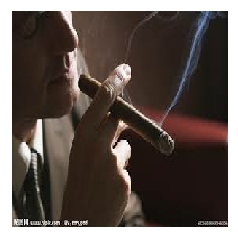

index = 1
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


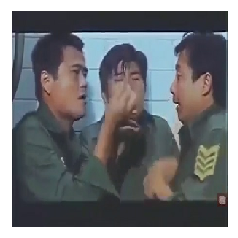

index = 2
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


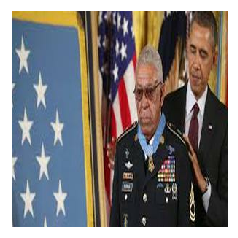

index = 3
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


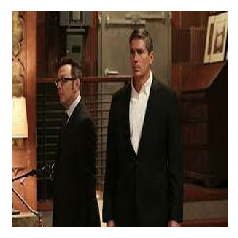

index = 4
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


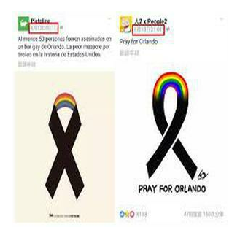

index = 5
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


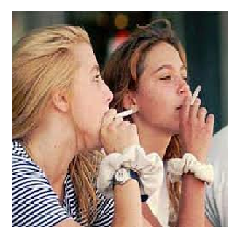

index = 6
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


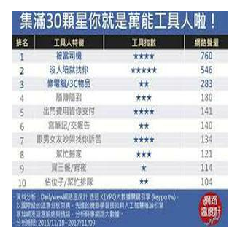

index = 7
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


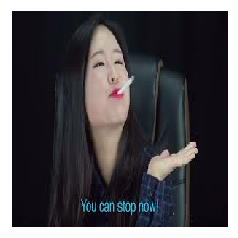

index = 8
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


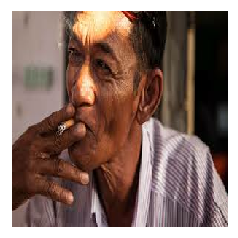

index = 9
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


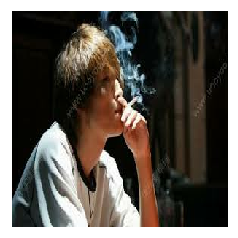

index = 10
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


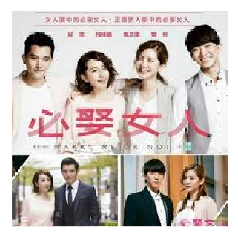

index = 11
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


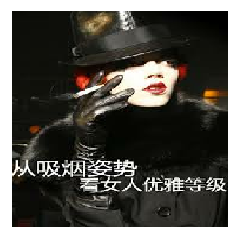

index = 12
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


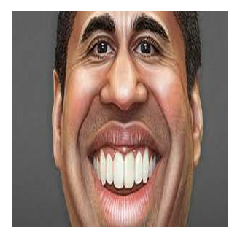

index = 13
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


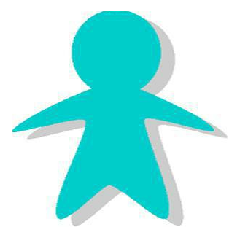

index = 14
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


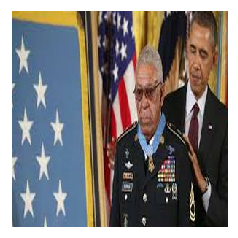

index = 15
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


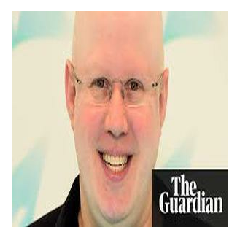

index = 16
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


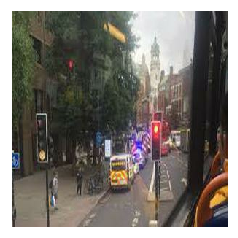

index = 17
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


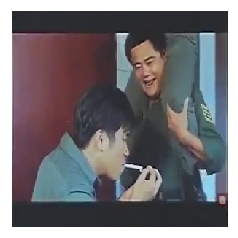

index = 18
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


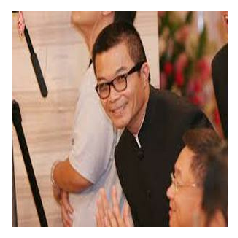

index = 19
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


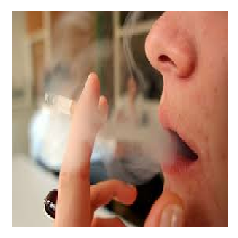

index = 20
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


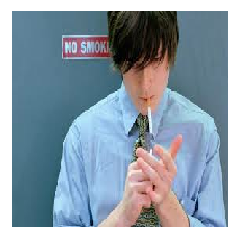

index = 21
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


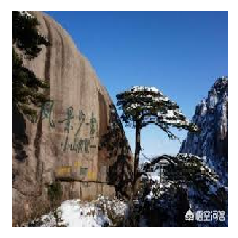

index = 22
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


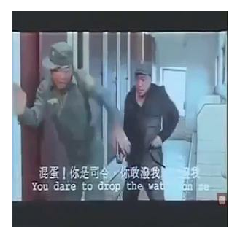

index = 23
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


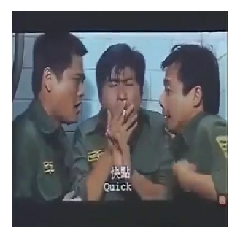

index = 24
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


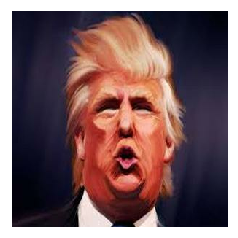

index = 25
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


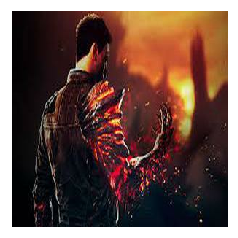

index = 26
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


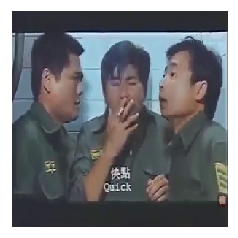

index = 27
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


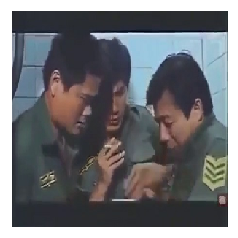

index = 28
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


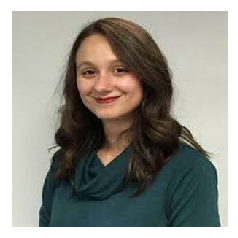

index = 29
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


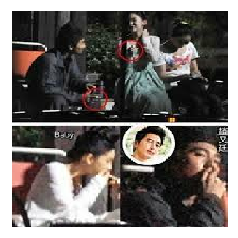

index = 30
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


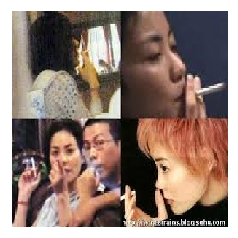

index = 31
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


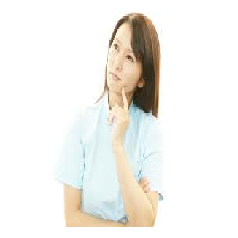

index = 32
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


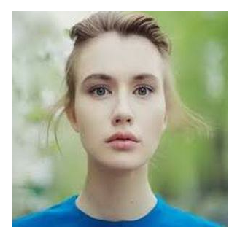

index = 33
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


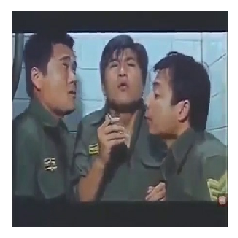

index = 34
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


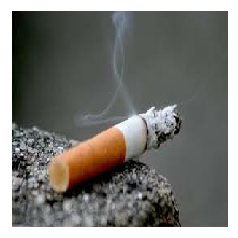

index = 35
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


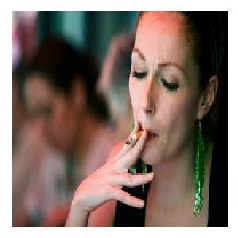

index = 36
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


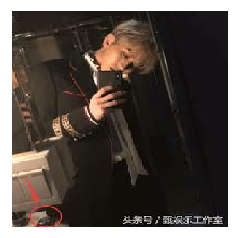

index = 37
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


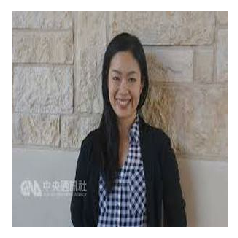

index = 38
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


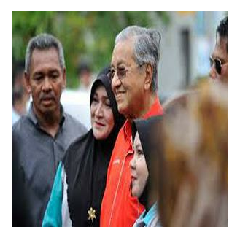

index = 39
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


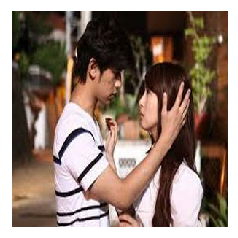

index = 40
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


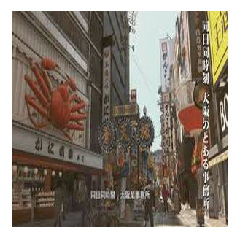

index = 41
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


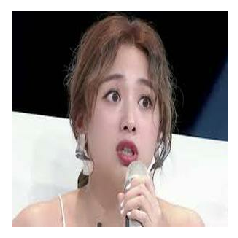

index = 42
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


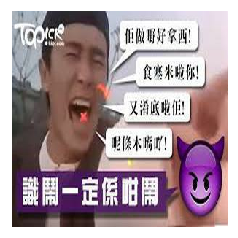

index = 43
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


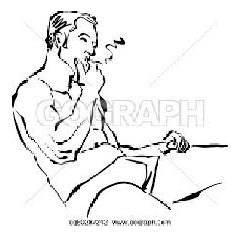

index = 44
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


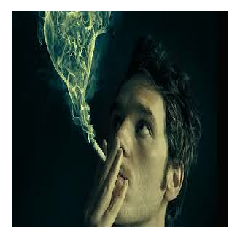

index = 45
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


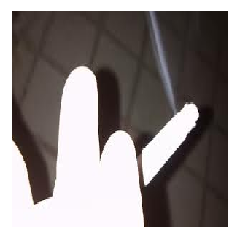

index = 46
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


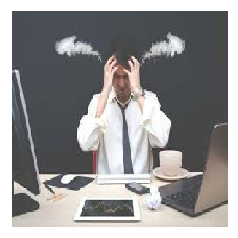

index = 47
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


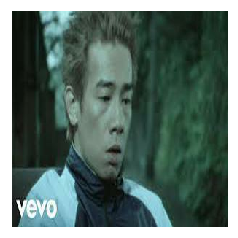

index = 48
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


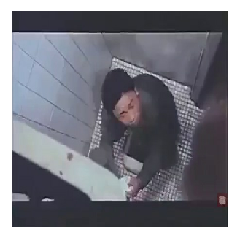

index = 49
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


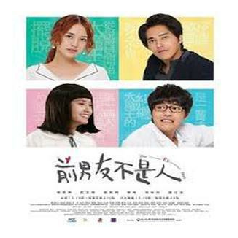

index = 50
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


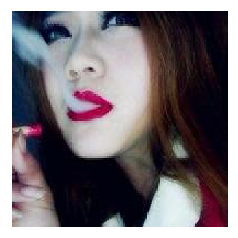

index = 51
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


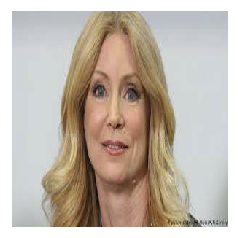

index = 52
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


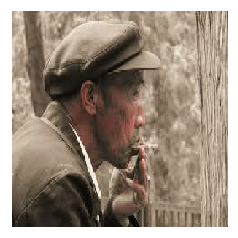

index = 53
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


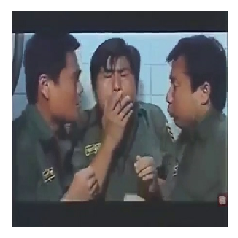

index = 54
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


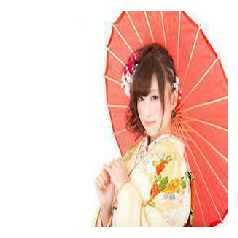

index = 55
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


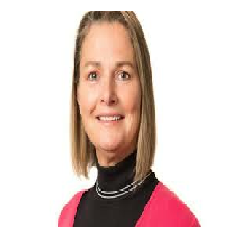

index = 56
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


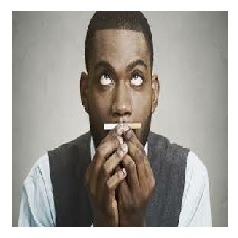

index = 57
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


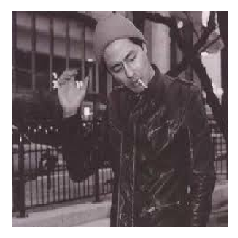

index = 58
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


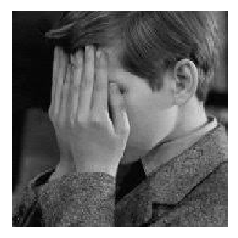

index = 59
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


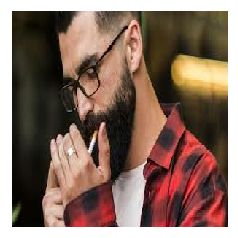

index = 60
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


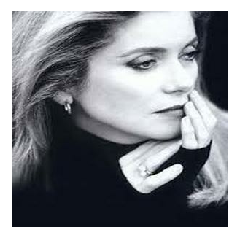

index = 61
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


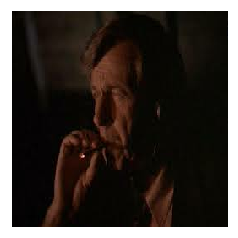

index = 62
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


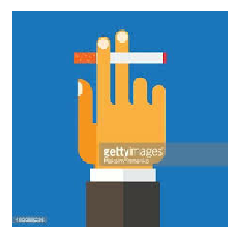

index = 63
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


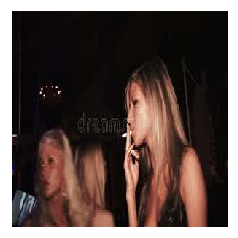

index = 64
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


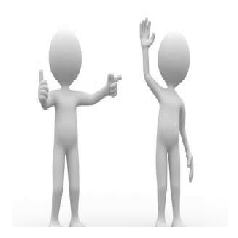

index = 65
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


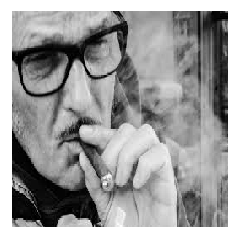

index = 66
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


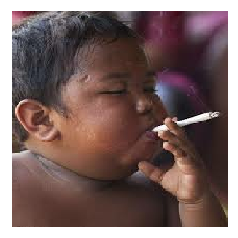

index = 67
labels= 1 predictions= 0 
1
0
label_name: smo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: smo


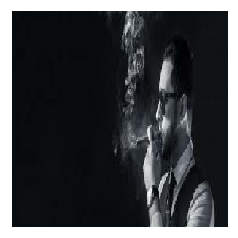

index = 68
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


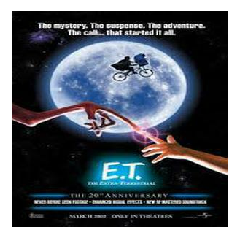

index = 69
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


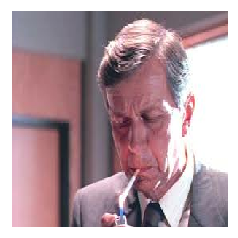

index = 70
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


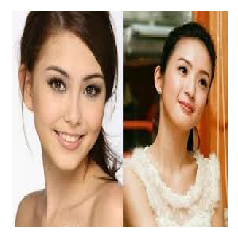

index = 71
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


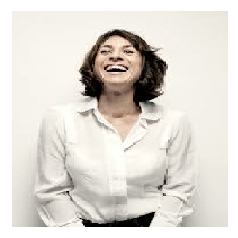

index = 72
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


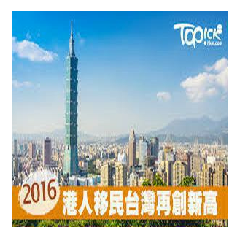

index = 73
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


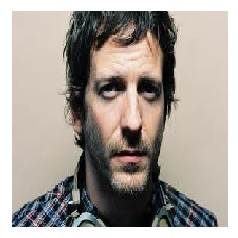

index = 74
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


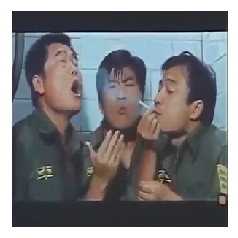

index = 75
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


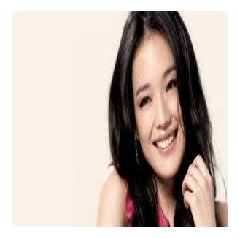

index = 76
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


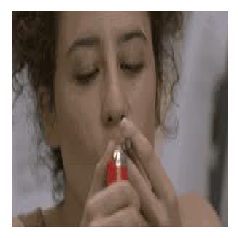

index = 77
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


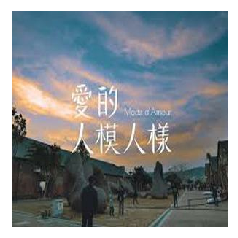

index = 78
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


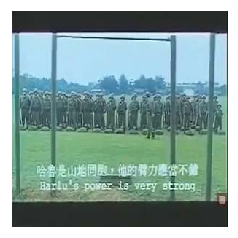

index = 79
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


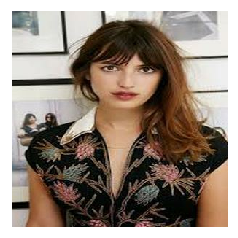

index = 80
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


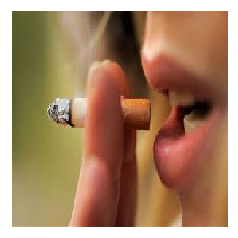

index = 81
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


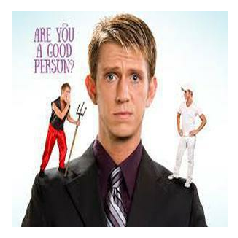

index = 82
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


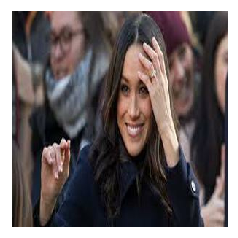

index = 83
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


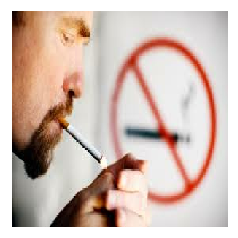

index = 84
labels= 1 predictions= 0 
1
0
label_name: smo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: smo


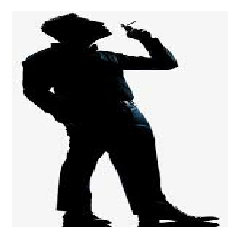

index = 85
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


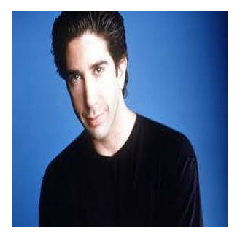

index = 86
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


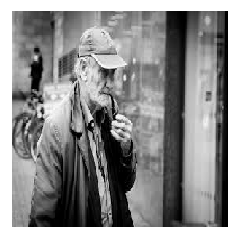

index = 87
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


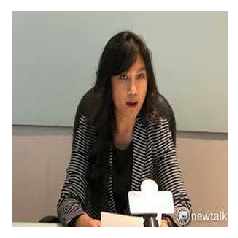

index = 88
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


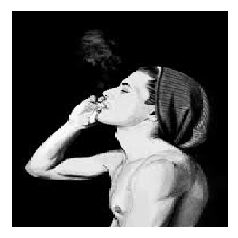

index = 89
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


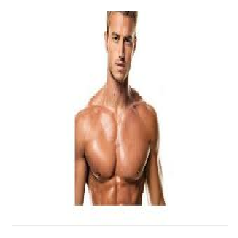

index = 90
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


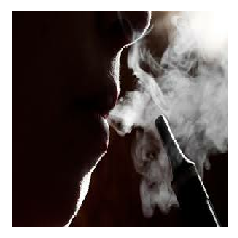

index = 91
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


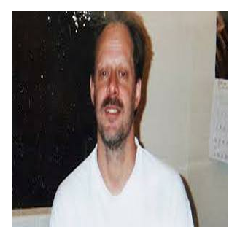

index = 92
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


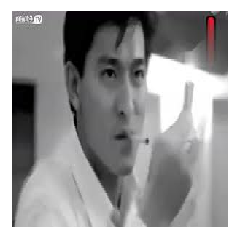

index = 93
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


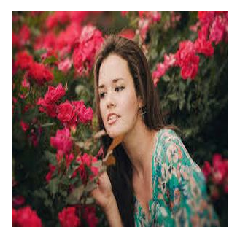

index = 94
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


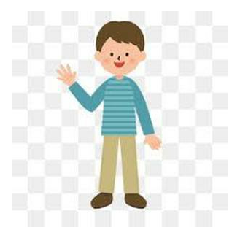

index = 95
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


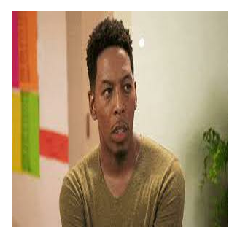

index = 96
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


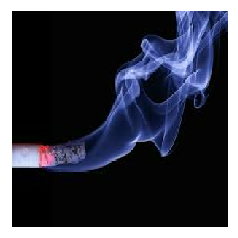

index = 97
labels= 0 predictions= 0 
0
0
label_name: nosmo
Prediction: nosmo
Prediction: nosmo 
 Ground Truth: nosmo


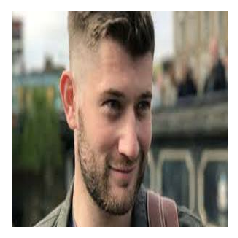

index = 98
labels= 1 predictions= 1 
1
1
label_name: smo
Prediction: smo
Prediction: smo 
 Ground Truth: smo


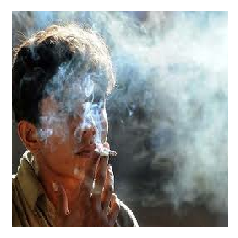

Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [9]:
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
import inception_preprocessing
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import time
import os
#from train_flowers import load_batch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
slim = tf.contrib.slim

#State your log directory where you can retrieve your model
log_dir = './out001/'

#Create a new evaluation log directory to visualize the validation process
log_eval = './log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = datasets_data_dir

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 100

#State the number of epochs to evaluate
num_epochs = 50

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)
file_pattern = 'smotfrecord_validation_%s.tfrecord'

def main():
    #Create log_dir for evaluation information
    if not os.path.exists(log_eval):
        os.mkdir(log_eval)

    #Just construct the graph from scratch again
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO)
        #Get the dataset first and load one batch of validation images and labels tensors. Set is_training as False so as to use the evaluation preprocessing
      
        dataset = get_split('validation', datasets_data_dir, file_pattern=file_pattern)
        print(dataset.data_sources)
        
        #image, raw_images, labels = load_batch(dataset, batch_size=batch_size)
        image, raw_images, labels = load_batch(dataset, batch_size = batch_size, is_training = False)
 
        
        #Create some information about the training steps
        num_batches_per_epoch = dataset.num_samples / batch_size
        num_steps_per_epoch = num_batches_per_epoch

        #Now create the inference model but set is_training=False
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(image, num_classes = num_classes, is_training = False)

        # #get all the variables to restore from the checkpoint file and create the saver function to restore
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)

        #Just define the metrics to track without the loss or whatsoever
        predictions = tf.argmax(end_points['Predictions'], 1)
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update)

        #Create the global step and an increment op for monitoring
        global_step = get_or_create_global_step()
        global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step
        
        #Create a evaluation step function
        def eval_step(sess, metrics_op, global_step):
           
            #Simply takes in a session, runs the metrics op and some logging information.
           
            start_time = time.time()
            _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
            time_elapsed = time.time() - start_time

            #Log some information
            print('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)' %(global_step_count, accuracy_value, time_elapsed))

            return accuracy_value


        #Define some scalar quantities to monitor
        tf.summary.scalar('Validation_Accuracy', accuracy)
        my_summary_op = tf.summary.merge_all()

        #Get your supervisor
        sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

        #Now we are ready to run in one session
        print(num_steps_per_epoch)
        print(num_epochs)
                
        with sv.managed_session() as sess:
            for step in range( num_epochs):
                
                sess.run(sv.global_step)
                #print vital information every start of the epoch as always
                if (step % num_batches_per_epoch) == 0:
                    print('Epoch: %s/%s' %(step / num_batches_per_epoch + 1, num_epochs))
                    
                    print('Current Streaming Accuracy: %f' %(sess.run(accuracy)))
                    
                #Compute summaries every 10 steps and continue evaluating
                if (step % 10) == 0:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    

                #Otherwise just run as per normal
                else:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

            #At the end of all the evaluation, show the final accuracy
            
             #Now we want to visualize the last batch's images just to see what our model has predicted
            raw_images, labels, predictions = sess.run([raw_images, labels, predictions])
            for i in range(99):
                
                image, label, prediction = raw_images[i], labels[i], predictions[i]
                print('index = %d' %(i))
               
                print('labels= %d predictions= %d ' %(labels[i] ,predictions[i]))
                
                prediction_name = dataset.labels_to_name[prediction],
                label_name = dataset.labels_to_name[label]
                
          
                print(label)
                print(prediction)
                label_name = dataset.labels_to_name[label]
                print('label_name: %s' %(label_name))
                prediction_name = dataset.labels_to_name[prediction]
                print('Prediction: %s' %(prediction_name))
               
                #text =('Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name))
                print('Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name))
                
                img_plot = plt.imshow(image)

                #Set up the plot and hide axes
                #plt.title(text)
                img_plot.axes.get_yaxis().set_ticks([])
                img_plot.axes.get_xaxis().set_ticks([])
                plt.show()

            
            print('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')
       
if __name__ == '__main__':
  main()

In [7]:
from __future__ import print_function
import tensorflow as tf
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
from tensorflow.python.framework import graph_util
slim = tf.contrib.slim

def CreatePbFile():
    image_size = 299
    num_classes = 2

    
    checkpoint_file = tf.train.latest_checkpoint(log_dir)

    with tf.Graph().as_default() as graph:
        
        images = tf.placeholder(shape=[None, image_size, image_size, 3], dtype=tf.float32, name = 'Placeholder_only')

        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = num_classes, is_training = False)

        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        #Setup graph def
        input_graph_def = graph.as_graph_def()
        output_node_names = "InceptionResnetV2/Logits/Predictions"
        output_graph_name = "./frozen_model_inception_resnet_v2_1218.pb"

        with tf.Session() as sess:
            saver.restore(sess, checkpoint_file)

            #Exporting the graph
            print ("Exporting graph...")
            output_graph_def = graph_util.convert_variables_to_constants(
                sess,
                input_graph_def,
                output_node_names.split(","))

            with tf.gfile.GFile(output_graph_name, "wb") as f:
                f.write(output_graph_def.SerializeToString())

CreatePbFile()    

INFO:tensorflow:Restoring parameters from ./out001/model.ckpt-22484
Exporting graph...
INFO:tensorflow:Froze 898 variables.
INFO:tensorflow:Converted 898 variables to const ops.


In [8]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2018-12-18 03:45:55
